# <p align="center">Post-Hoc Concept Disentanglement: From Correlated to Isolated Concept Representations</p>

## 1) Dataset

Let's start by loading the CelebA dataset.

In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from datasets import get_dataset

IMG_SIZE = 224
DATASET_NAME = "celeba"
DATASET_DIRS = ["/Users/erogullari/datasets/"]      # change to the directory containing CelebA

dataset = get_dataset(DATASET_NAME)(data_paths=DATASET_DIRS,
                                    normalize_data=True,
                                    image_size=IMG_SIZE)

len(dataset)

Using subset


20260

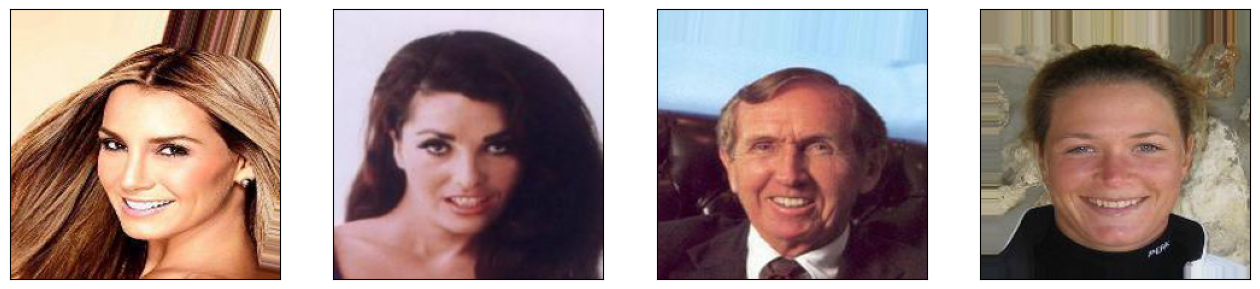

In [3]:
import torchvision.transforms as T

inverse_transform = T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])

# Some samples
fig, axs = plt.subplots(1,4, figsize=(16,4))
for i, ax in enumerate(axs):
    img_tensor, _ = dataset[i]
    img = inverse_transform(img_tensor).permute(1,2,0)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

CelebA provides concept-level annotations for each sample, which will be useful later on.

In [4]:
# Concepts present
concepts = list(dataset.sample_ids_by_concept.keys())
print(f"Number of concepts present: {len(concepts)}")
print("Some examples:")
for attr in concepts[:5]:
    print(f"    {attr} --> {len(dataset.sample_ids_by_concept[attr])}")

Number of concepts present: 40
Some examples:
    5_o_Clock_Shadow --> 2289
    Arched_Eyebrows --> 5491
    Attractive --> 10391
    Bags_Under_Eyes --> 4134
    Bald --> 446


In [5]:
# Binary labels tensor
labels = torch.tensor(dataset.attributes.to_numpy(), dtype=torch.float32)
labels.shape

torch.Size([20260, 40])

Finally, let's look at the correlation matrix of CelebA w.r.t our 40 concept labels. As can be seen, there are 2 natural groupings on the matrix, namely the concepts related to female- and male-associated concepts.

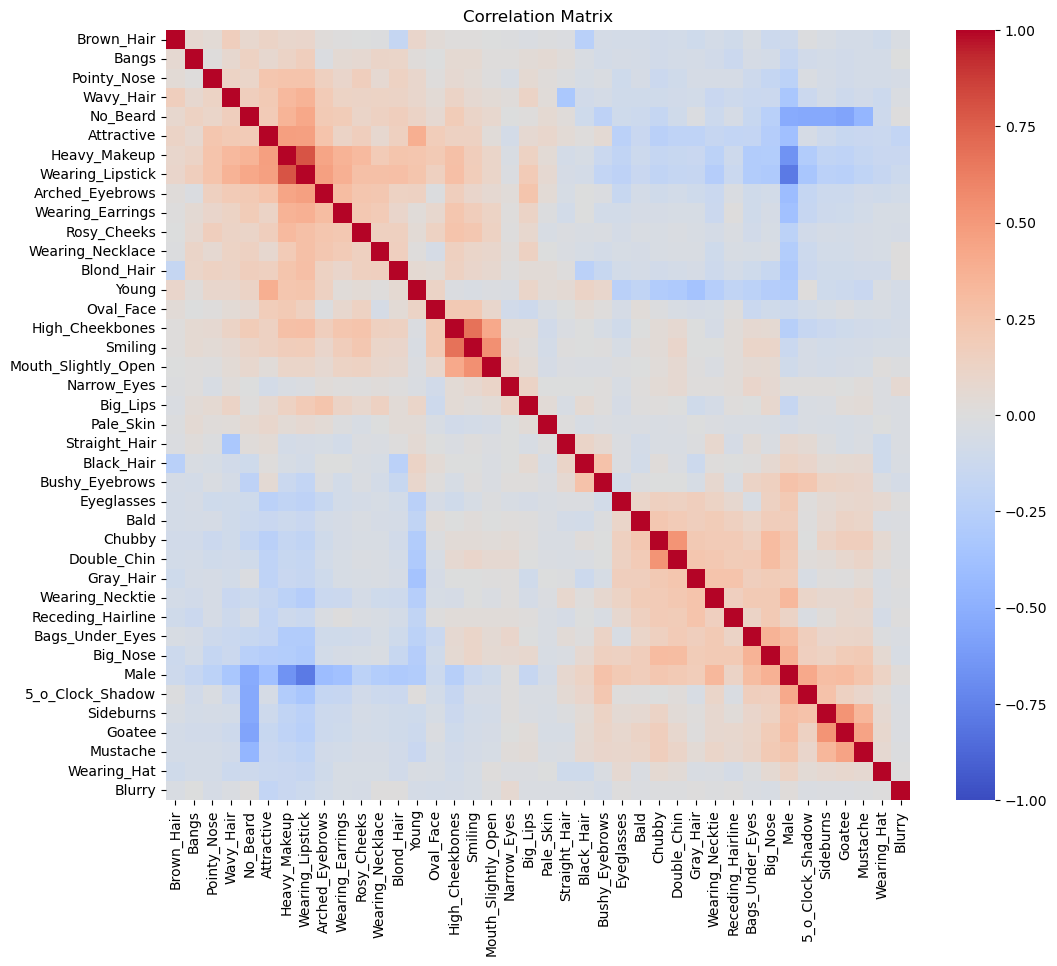

In [6]:
from utils.sim_matrix import visualize_sim_matrix

mean_centered = labels - labels.mean(dim=0, keepdim=True)
cov_matrix = mean_centered.T @ mean_centered / (labels.shape[0] - 1)
std_dev = labels.std(dim=0, keepdim=True)
correlation_matrix = cov_matrix / (std_dev.T @ std_dev)
visualize_sim_matrix(correlation_matrix, concepts, 'Correlation Matrix')

## 2) Model

Furthermore, let's download the weights for the VGG16 model. Alternatively, the weights can be found [here](https://drive.google.com/drive/folders/1Vv_Dq-1hDcYl-A-TuXNH8jRDKe9-BR-k?usp=sharing) under checkpoints.

In [7]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1L7O838TRldaWQkGKIFGvwxVe_agnyFAn' -O checkpoint_vgg16_celeba.pth
# !mv checkpoint_vgg16_celeba.pth checkpoints/

In [8]:
from models import get_fn_model_loader

MODEL_NAME = "vgg16"
N_CLASSES = 2
CHECKPT_PATH = "checkpoints/checkpoint_vgg16_celeba.pth"
device = 'cpu'      # Change to your device

model = get_fn_model_loader(model_name=MODEL_NAME)(n_class=N_CLASSES, ckpt_path=CHECKPT_PATH).to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 3) Extract Latent Activations

And extract latent activations on the 'features.28' layer of VGG16.

In [9]:
def get_features(batch, layer_name, attribution, cav_mode="max", device="cpu"):
    batch.requires_grad = True
    dummy_cond = [{"y": 0} for _ in range(len(batch))]
    record_layer=[layer_name]
    attr = attribution(batch.to(device), dummy_cond, record_layer=record_layer)
    if cav_mode == "full":
        features = attr.activations[layer_name]
    else:
        acts = attr.activations[layer_name]
        features = acts.flatten(start_dim=2).max(2)[0]
    return features

In [11]:
from crp.attribution import CondAttribution
from torch.utils.data import DataLoader

LAYER = "features.28"

# File path to save/load latent variables
latent_file_path = "variables/latents_celeba_vgg16.pt"
attribution = CondAttribution(model)

# Check if the latent variables have been precomputed and saved
if os.path.exists(latent_file_path):
    x_latent_all = torch.load(latent_file_path)
    print(f"Loaded latent variables from {latent_file_path}")
else:
    # Compute latent embeddings
    BATCH_SIZE = 16
    CAV_MODE = "max"
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    x_latent_all = None
    for x, y in tqdm.tqdm(dataloader):
        x_latent = get_features(x, LAYER, attribution, CAV_MODE, device)
        x_latent = x_latent.detach().cpu()
        x_latent_all = x_latent if x_latent_all is None else torch.cat((x_latent_all, x_latent))

    # Save the computed latent variables for future use
    torch.save(x_latent_all, latent_file_path)
    print(f"Computed and saved latent variables to {latent_file_path}")

x_latent_all.shape

Loaded latent variables from variables/latents_celeba_vgg16.pt


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_34656/3280364800.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_latent_all = torch.load(latent_file_path)


torch.Size([20260, 512])

## 4) Baseline CAVs

First, let's have a look at the cosine similarity matrix of baseline (entangled) CAVs and compare it to the correlation matrix from earlier.

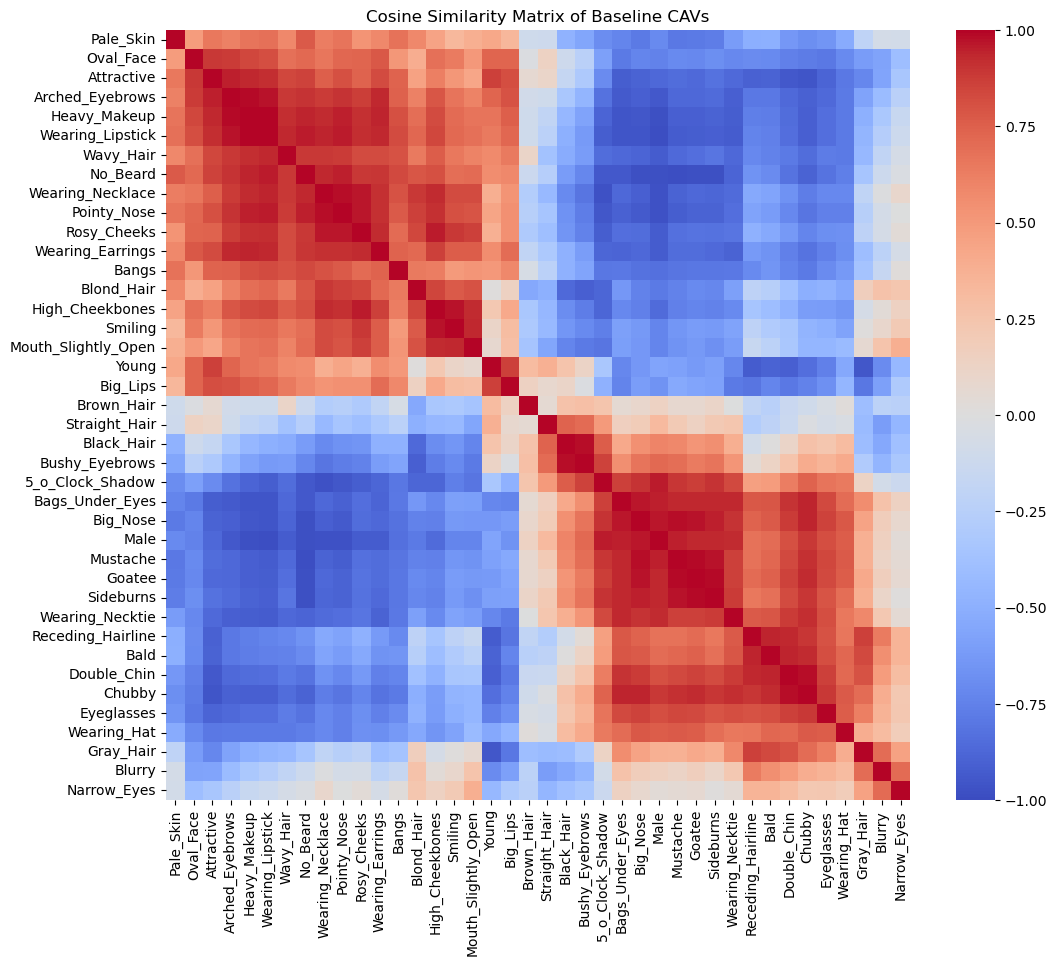

In [12]:
from utils.cav import compute_all_cavs
from utils.sim_matrix import visualize_sim_matrix

# Baseline CAVs
cavs_original = compute_all_cavs(x_latent_all, labels)
cos_sim_original = cavs_original @ cavs_original.T
visualize_sim_matrix(cos_sim_original, concepts, 'Cosine Similarity Matrix of Baseline CAVs')

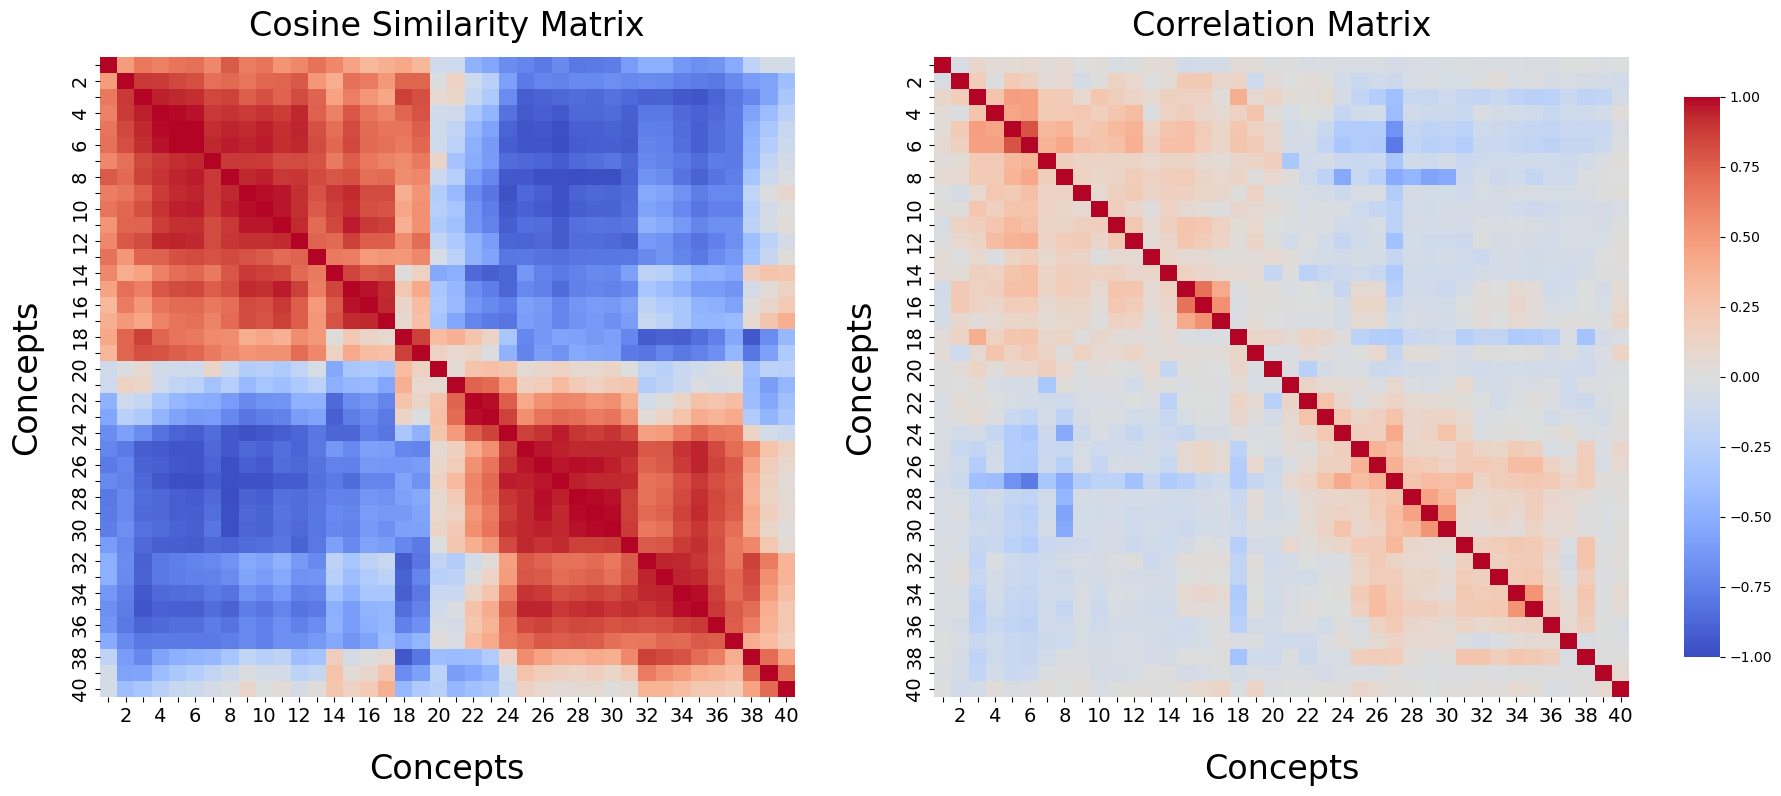

In [13]:
from utils.sim_matrix import reorder_similarity_matrix

def visualize_matrices(matrix1, matrix2):
    # Reorder the first matrix and get the reordering indices
    before_np, order = reorder_similarity_matrix(matrix1.cpu().numpy())
    after_np = matrix2.cpu().numpy()[np.ix_(order, order)]
    numbered_labels = [str(i + 1) for i in range(40)]
    reduced_labels = [numbered_labels[i] if i % 2 == 1 else "" for i in range(40)]  # Keep every second label

    fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1]})
    cbar_ax = fig.add_axes([.93, 0.15, .02, .7])  # Shared colorbar position
    fontsize = 24           # overall fontsize
    label_fontsize = 14     # number sizes on the axis
    labelpad_value = 20     # distance 'concepts' from the matrix

    # Cosine Similarity Matrix
    sns.heatmap(before_np, ax=axes[0], cbar=True, cbar_ax=cbar_ax,
                cmap='coolwarm', vmin=-1, vmax=1, 
                xticklabels=reduced_labels, yticklabels=reduced_labels)
    axes[0].set_title("Cosine Similarity Matrix", fontsize=fontsize, pad=15)
    axes[0].set_xlabel("Concepts", fontsize=fontsize, labelpad=labelpad_value)
    axes[0].set_ylabel("Concepts", fontsize=fontsize, labelpad=labelpad_value)
    axes[0].tick_params(axis='both', which='major', labelsize=label_fontsize)  # Increase tick label font size

    # Correlation Matrix
    sns.heatmap(after_np, ax=axes[1], cbar=False,
                cmap='coolwarm', vmin=-1, vmax=1,
                xticklabels=reduced_labels, yticklabels=reduced_labels)
    axes[1].set_title("Correlation Matrix", fontsize=fontsize, pad=15)
    axes[1].set_xlabel("Concepts", fontsize=fontsize, labelpad=labelpad_value)
    axes[1].set_ylabel("Concepts", fontsize=fontsize, labelpad=labelpad_value)
    axes[1].tick_params(axis='both', which='major', labelsize=label_fontsize)  # Increase tick label font size

    # Add the overall title and adjust layout
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.2)
    
    return fig

visualize_matrices(cos_sim_original, correlation_matrix);

As can be seen, the cosine similarities of CAVs reflect the correlation matrix of the dataset.

## 5) Disentangling CAVs

Let's use our proposed method to disentangle CAVs.

In [14]:
from utils.metrics import get_accuracy, get_avg_precision, get_uniqueness, compute_auc_performance

def train_epoch(dataloader, cav_model, weights, optimizer, device):
    
    epoch_cav_loss = 0.0
    epoch_orthogonality_loss = 0.0
    for x_batch, labels_batch in dataloader:
        optimizer.zero_grad()

        # Move data to device
        x_batch = x_batch.to(device)
        labels_batch = labels_batch.to(device)

        # Forward
        cav_loss, orthogonality_loss = cav_model.train_step(x_batch, labels_batch, weights)

        # Total Loss
        total_batch_loss = cav_loss + orthogonality_loss

        # Backpropagation
        total_batch_loss.backward()
        optimizer.step()

        epoch_cav_loss += cav_loss.item()
        epoch_orthogonality_loss += orthogonality_loss.item()

    avg_cav_loss = epoch_cav_loss / len(dataloader)
    avg_orthogonality_loss = epoch_orthogonality_loss / len(dataloader)
    
    return avg_cav_loss, avg_orthogonality_loss

def eval_epoch(test_data, test_labels, cav_model, device):
    cavs, _ = cav_model.get_params()
    n_concepts, n_features = cavs.shape[-2], cavs.shape[-1]
    test_data = test_data.to(device)
    cavs = cavs.to(device)
    metrics = {}
    
    with torch.no_grad():
        # Normalize CAVs
        cavs_normalized = cavs / torch.norm(cavs, dim=1, keepdim=True)

        # Predictions and labels for classification metrics
        x_normalized = test_data / test_data.norm(dim=1, keepdim=True) 
        logits = x_normalized @ cavs_normalized.T
        probs = logits.softmax(dim=1)

        # Compute metrics
        metrics['accuracy'] = get_accuracy(probs, test_labels)
        metrics['avg_precision'] = get_avg_precision(probs, test_labels)

        # Compute AUC for individual concepts
        metrics['auc_scores'] = compute_auc_performance(cavs, test_data, test_labels)

        # Uniqueness and Cosine Sim
        metrics['uniqueness'] = get_uniqueness(cavs)
        metrics['cos_sim_matrix'] = (cavs_normalized @ cavs_normalized.T).cpu()
    
    test_data = test_data.cpu()
    
    return metrics

def initialize_weights(C, labels, alpha, beta, n_targets, device):
    weights = alpha * torch.ones_like(C, device=device)

    if beta != None:
        # Extract the rows and cols
        similarities = torch.triu(C.abs(), diagonal=1).clone()
        sorted_indices = torch.argsort(similarities.flatten(), descending=True)
        rows = sorted_indices // similarities.size(1)
        cols = sorted_indices % similarities.size(1)
        
        # Iterate through ordered pairs and select the first k valid ones
        selected_pairs = []
        for i, j in zip(rows.tolist(), cols.tolist()):
            if len(set(torch.where(labels[:, i] == 1)[0].tolist()).intersection(
                   set(torch.where(labels[:, j] == 1)[0].tolist()))) != 0:
                selected_pairs.append((i, j))
                
            if len(selected_pairs) == n_targets:
                break
        
        # Assign weights for the selected pairs
        for i, j in selected_pairs:
            weights[i, j] = np.sqrt(beta)
            weights[j, i] = np.sqrt(beta)

    return weights

You can either run the training loop below or load the results provided [here](https://drive.google.com/drive/folders/1Vv_Dq-1hDcYl-A-TuXNH8jRDKe9-BR-k?usp=sharing) under results.

In [27]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from models.signal_cav import SignalCAV
from torch import optim
import pickle

dir_path = "results/cavs_vgg16_celeba"
# dir_path = ""

if os.path.exists(dir_path):
    best_cavs = torch.load(f"{dir_path}/cavs.pt", weights_only=True)
    with open(f"{dir_path}/metrics/auc_hist.pkl", 'rb') as f:
        auc_scores_history = pickle.load(f)
    with open(f"{dir_path}/metrics/cav_loss_hist.pkl", 'rb') as f:
        cav_loss_history = pickle.load(f)
    with open(f"{dir_path}/metrics/orth_loss_hist.pkl", 'rb') as f:
        orthogonality_loss_history = pickle.load(f)
    with open(f"{dir_path}/metrics/uniqueness_hist.pkl", 'rb') as f:
        uniqueness_history = pickle.load(f)
    with open(f"{dir_path}/metrics/precision_hist.pkl", 'rb') as f:
        avg_precision_hist = pickle.load(f)
    early_exit_epoch = None
    print(f"Variables loaded from '{dir_path}'.")

    TRAIN_RATIO = 0.9
    tensor_ds = TensorDataset(x_latent_all, labels)
    total_size = len(tensor_ds)
    train_size = int(total_size * 0.9)
    _, test_dataset = random_split(tensor_ds, [train_size, total_size - train_size])
    test_data, test_labels = zip(*test_dataset)
    test_data = torch.stack(test_data).to(device)
    test_labels = torch.stack(test_labels).to(device)

    C = cavs_original @ cavs_original.T
    _, order = reorder_similarity_matrix(C.cpu().numpy())
else: 
    # Hyperparameters
    ALPHA = 0.1
    BETA = None
    N_EPOCHS = 150
    LR = 1e-3
    N_TARGETS = 50 if BETA is not None else None        
    BATCH_SIZE = 32
    TRAIN_RATIO = 0.9
    RANDOM_SEED = 42

    torch.manual_seed(RANDOM_SEED)
    device = 'mps'      # change to your device

    # Prepare data for training
    tensor_ds = TensorDataset(x_latent_all, labels)
    total_size = len(tensor_ds)
    train_size = int(total_size * 0.9)
    train_dataset, test_dataset = random_split(tensor_ds, [train_size, total_size - train_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_data, test_labels = zip(*test_dataset)
    test_data = torch.stack(test_data).to(device)
    test_labels = torch.stack(test_labels).to(device)

    # Prepare CAV model
    cavs = cavs_original.clone().to(device)
    b = torch.randn_like(cavs, device=device)
    cav_model = SignalCAV(cavs, b, device=device)
    optimizer = optim.SGD(cav_model.parameters(), lr=LR)

    # Initialize Weights
    C = cavs_original @ cavs_original.T
    _, order = reorder_similarity_matrix(C.cpu().numpy())
    weights = ALPHA * torch.ones_like(C, device=device)
    if BETA != None:
        similarities = torch.triu(C.abs(), diagonal=1).clone()
        sorted_indices = torch.argsort(similarities.flatten(), descending=True)
        rows = sorted_indices // similarities.size(1)
        cols = sorted_indices % similarities.size(1)
        selected_pairs = []
        for i, j in zip(rows.tolist(), cols.tolist()):
            if len(set(torch.where(labels[:, i] == 1)[0].tolist()).intersection(
                    set(torch.where(labels[:, j] == 1)[0].tolist()))) != 0:
                selected_pairs.append((i, j))
                
            if len(selected_pairs) == N_TARGETS:
                break

        for i, j in selected_pairs:
            weights[i, j] = np.sqrt(BETA)
            weights[j, i] = np.sqrt(BETA)
        
    # Initialize metrics storage
    cav_loss_history = []
    orthogonality_loss_history = []
    auc_scores_history = []
    uniqueness_history = []
    avg_precision_hist = []

    # Early exit variables
    best_uniqueness = 0.0
    uniqueness_epsilon = 0.01
    best_cavs = None
    early_exit_epoch = 0

    ### MAIN LOOP ###
    for epoch in tqdm(range(N_EPOCHS+1), desc="Epochs"):
        # Train for one epoch
        epoch_cav_loss, epoch_orth_loss = train_epoch(train_loader, cav_model, weights, optimizer, device)
        cav_loss_history.append(epoch_cav_loss)
        orthogonality_loss_history.append(epoch_orth_loss)
        
        # Evaluation every 10 epochs
        if epoch % 10 == 0:
            metrics = eval_epoch(test_data, test_labels, cav_model, device)
            auc_scores_history.append(metrics['auc_scores'])
            uniqueness_history.append(metrics['uniqueness'])
            avg_precision_hist.append(metrics['avg_precision'])
            mean_auc = np.mean(metrics['auc_scores'])
            mean_uniqueness = np.mean(metrics['uniqueness'])

            tqdm.write(f"CAV Loss:  {epoch_cav_loss:.4f} | Orth Loss: {epoch_orth_loss:.4f}")
            tqdm.write(f"AuC Score: {mean_auc:.4f} | Uniqueness: {mean_uniqueness:.4f}")

            if mean_uniqueness > best_uniqueness + uniqueness_epsilon:
                best_uniqueness = mean_uniqueness
                early_exit_epoch = epoch
                best_cavs, _ = cav_model.get_params()

Variables loaded from 'results/cavs_vgg16_celeba'.


Plot the metrics progression over epochs.

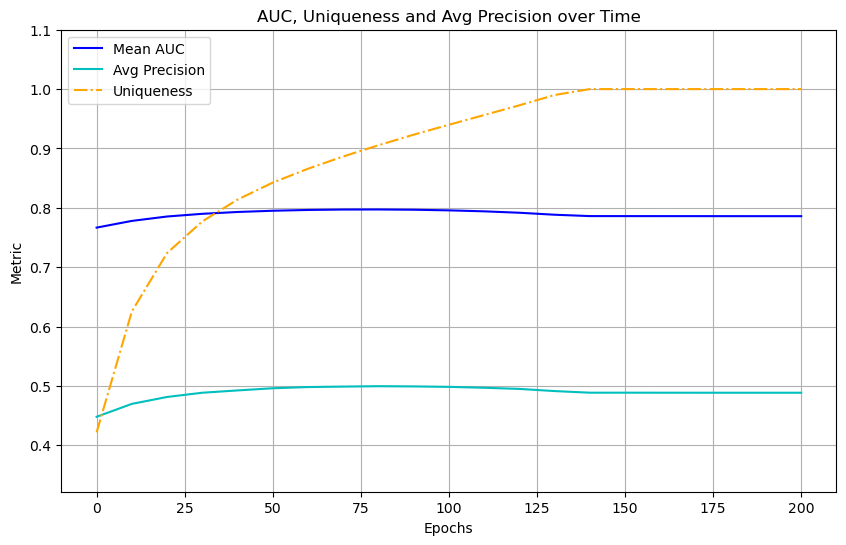

In [21]:
from utils.visualizations import plot_metrics_over_time

cav_performance_history = np.mean(np.array(auc_scores_history), axis=1)
cav_uniqueness_history = np.mean(np.array(uniqueness_history), axis=1)
epochs_logged = [10*i for i in range(len(cav_performance_history))]
plot_metrics_over_time(
    epochs_logged=epochs_logged,
    cav_performance_history=cav_performance_history,
    avg_precision_hist=avg_precision_hist,
    cav_uniqueness_history=cav_uniqueness_history,
    threshold=None,
    early_exit_epoch=early_exit_epoch       # Corresponds to the red vertical line where early exit's been made
);

## 6) Evaluation

We can now compare the cosine similarity matrices before and after disentanglement.

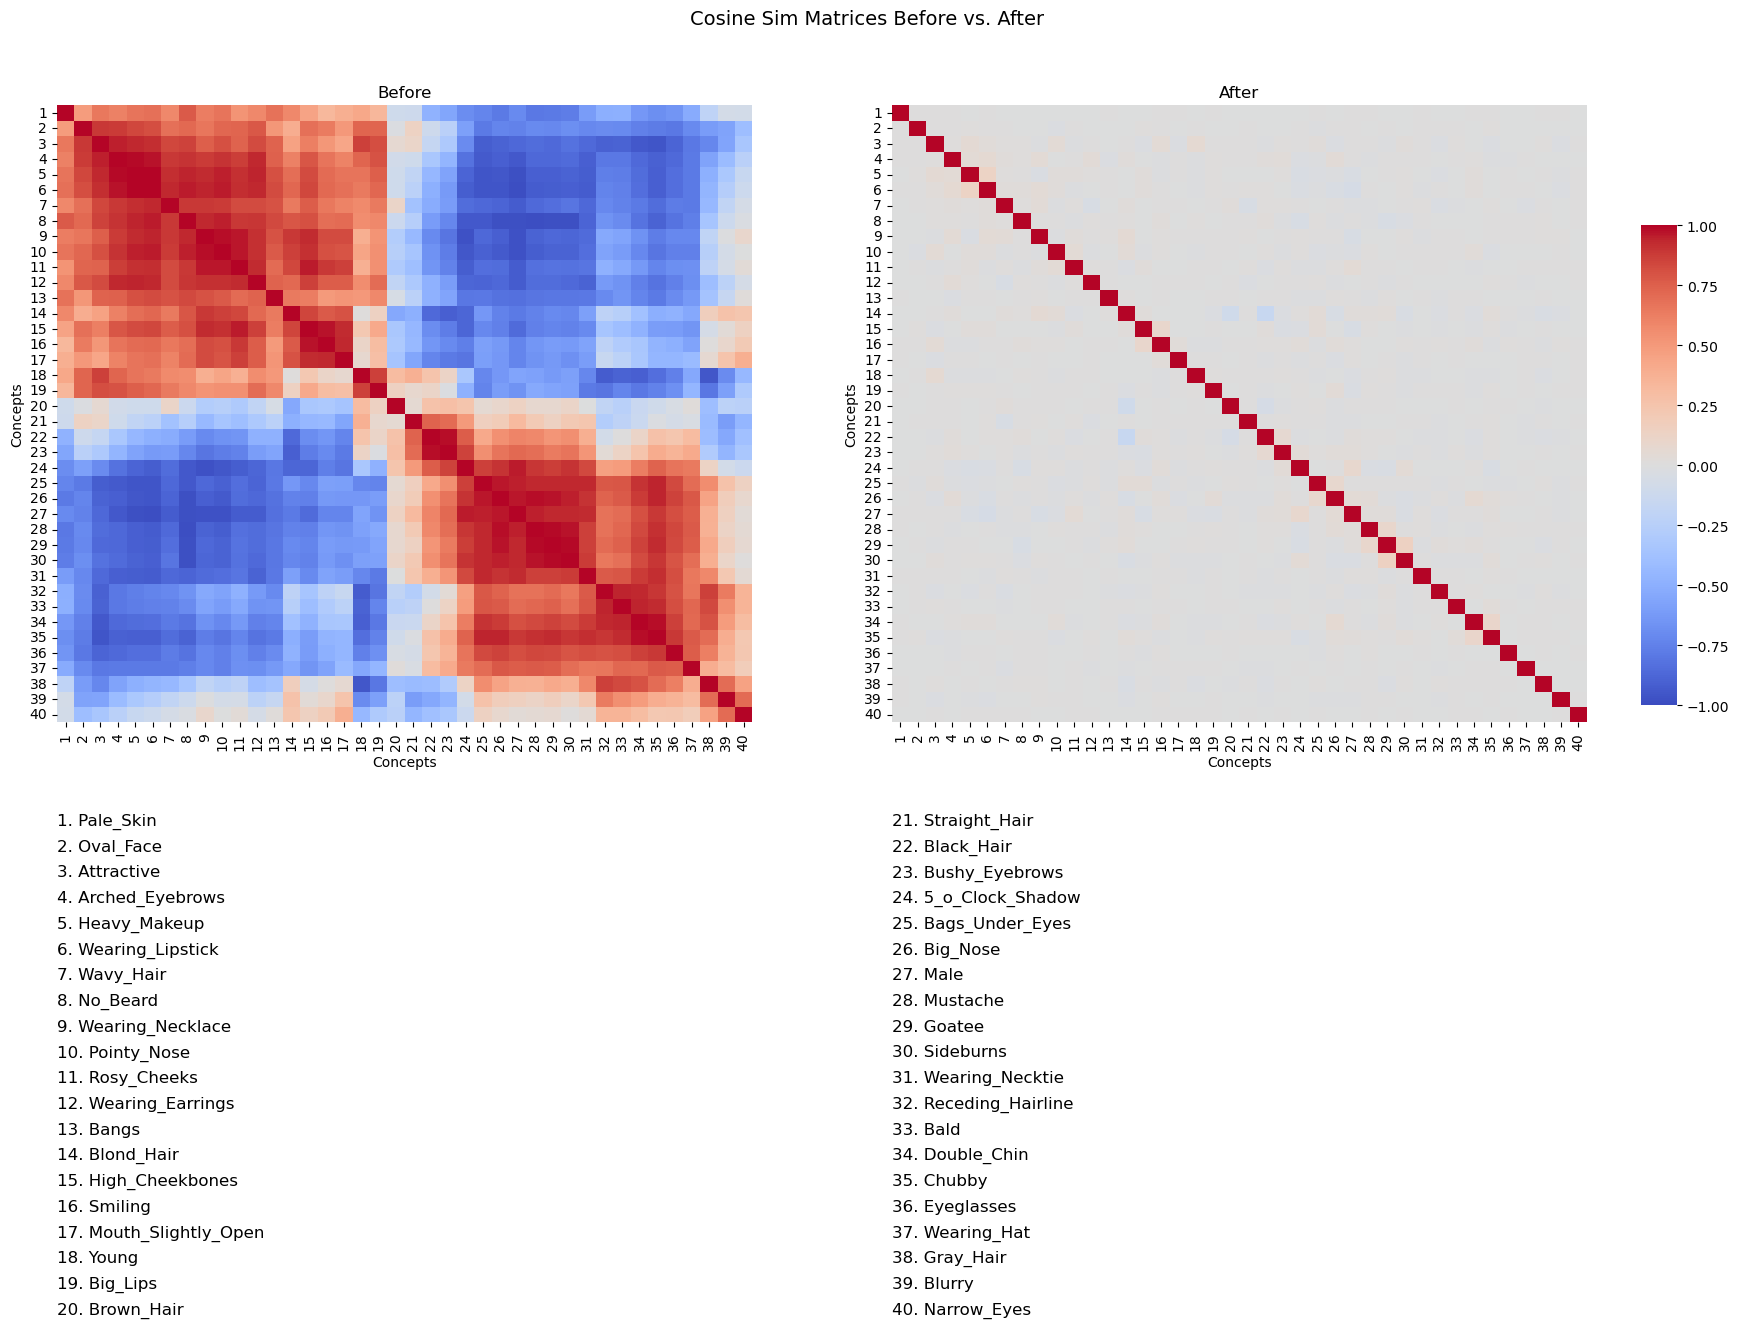

In [22]:
from utils.sim_matrix import visualize_before_after_sim_matrices

cavs_orthogonal = best_cavs / torch.linalg.norm(best_cavs, dim=1, keepdim=True)
cos_sim_after = cavs_orthogonal @ cavs_orthogonal.T
visualize_before_after_sim_matrices(cos_sim_original, cos_sim_after, concepts)

Furthermore, let's look at the AUROC and orthogonality metrics for each concept before and after disentanglement.

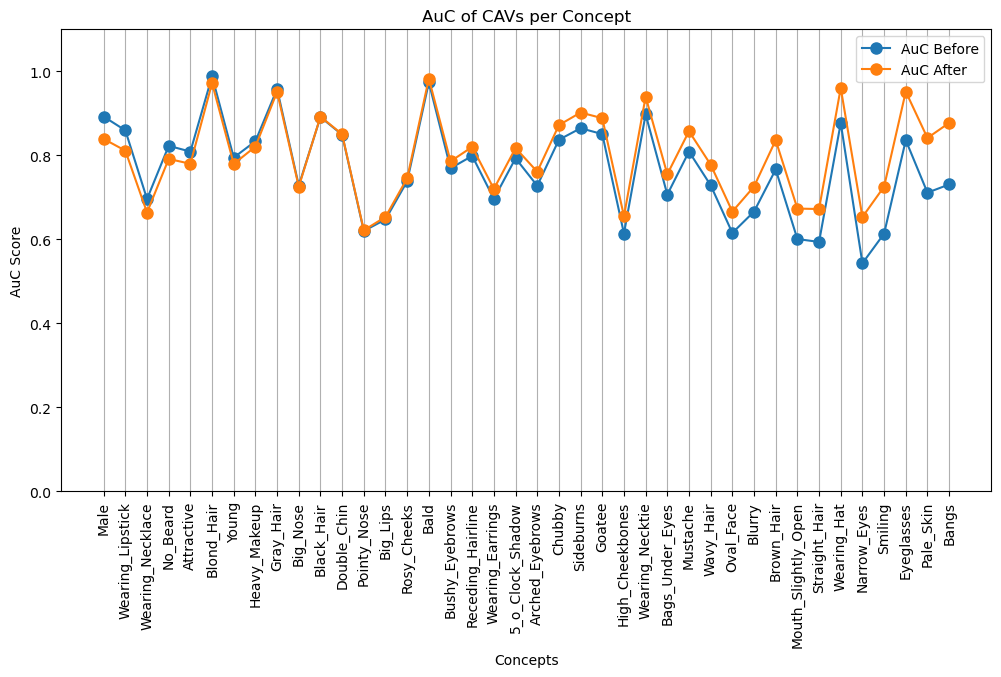

In [23]:
from utils.visualizations import plot_auc_before_after, plot_uniqueness_before_after

auc_before = compute_auc_performance(cavs_original, test_data, test_labels)
auc_after = compute_auc_performance(cavs_orthogonal, test_data, test_labels)
auc_diff = np.array(auc_after) - np.array(auc_before)
sorted_indices_auc = np.argsort(auc_diff)
sorted_concepts_auc = [concepts[i] for i in sorted_indices_auc]
sorted_auc_before = [auc_before[i] for i in sorted_indices_auc]
sorted_auc_after = [auc_after[i] for i in sorted_indices_auc]
plot_auc_before_after(
    auc_before=sorted_auc_before,
    auc_after=sorted_auc_after,
    concepts=sorted_concepts_auc
)

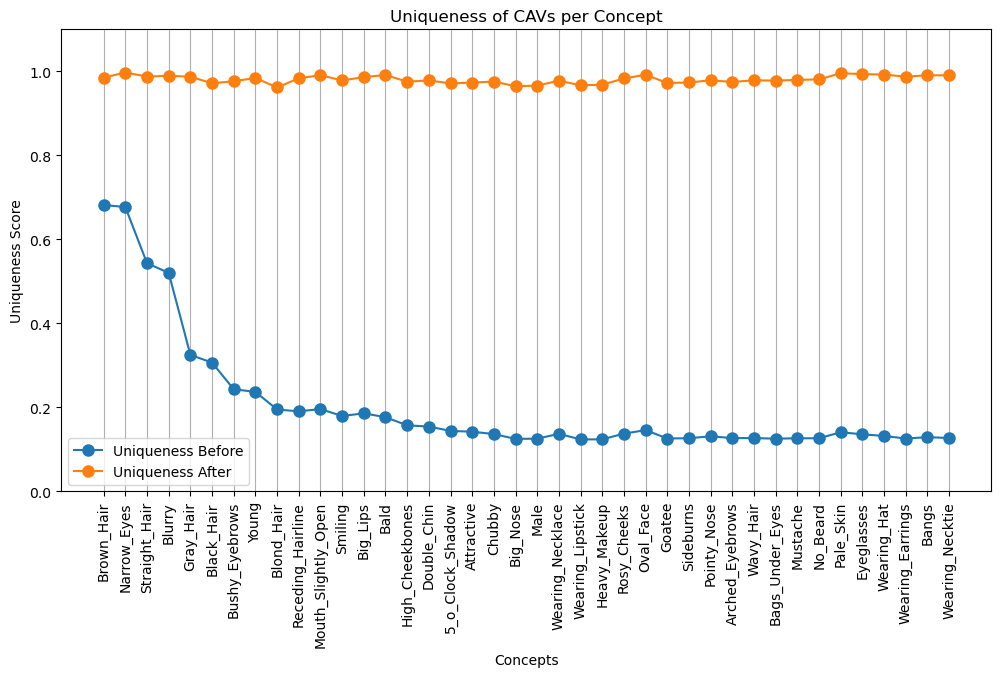

In [24]:
uniqueness_before = get_uniqueness(cos_sim_original)
uniqueness_after = get_uniqueness(cos_sim_after)
unq_diff = np.array(uniqueness_after) - np.array(uniqueness_before)
sorted_indices_unq = np.argsort(unq_diff)
sorted_concepts_unq = [concepts[i] for i in sorted_indices_unq]
sorted_uniqueness_before = [uniqueness_before[i] for i in sorted_indices_unq]
sorted_uniqueness_after = [uniqueness_after[i] for i in sorted_indices_unq]
plot_uniqueness_before_after(
    uniqueness_before=sorted_uniqueness_before,
    uniqueness_after=sorted_uniqueness_after,
    concepts=sorted_concepts_unq
)

We can also look at the relative AUROC change distribution.

/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_34656/1223049055.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
  auc_hist = torch.tensor(auc_scores_history)


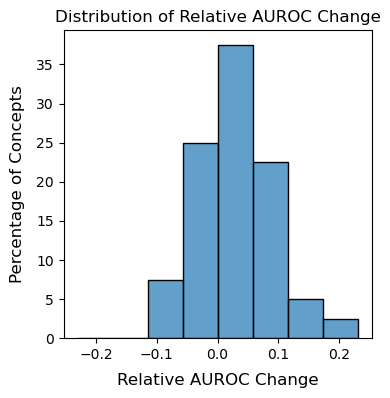

In [25]:
def plot_relative_auroc_change_histogram(auc_before, auc_after, num_bins=10, save_path=None):
    # Params
    fontsize=12
    labelpad=8

    # Convert to numpy arrays for computation
    auc_before = np.array(auc_before)
    auc_after = np.array(auc_after)
    
    # Compute relative change: (after - before) / before
    relative_change = (auc_after - auc_before) / auc_before
    
    # Compute weights so that the histogram represents percentages
    bound = max(np.abs(np.min(relative_change)), np.abs(np.max(relative_change)))
    bins = np.linspace(-bound, bound, num_bins + 1)
    # bins = np.linspace(np.min(relative_change), np.max(relative_change), num_bins + 1)
    
    plt.figure(figsize=(4, 4))
    ax = sns.histplot(relative_change, bins=bins, stat='percent', edgecolor='black', alpha=0.7)
    ax.set_box_aspect(1)
    plt.xlabel("Relative AUROC Change", fontsize=fontsize, labelpad=labelpad)
    plt.ylabel("Percentage of Concepts", fontsize=fontsize, labelpad=labelpad)
    plt.title("Distribution of Relative AUROC Change", fontsize=fontsize)
    # plt.grid(axis='y', linestyle='--', linewidth=0.5)
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

auc_hist = torch.tensor(auc_scores_history)
plot_relative_auroc_change_histogram(auc_hist[0,:], auc_hist[-1,:], num_bins=8);

Similarly for the 2 natural groups of female- and male-associated concepts.

/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_34656/2079902889.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fontsize)


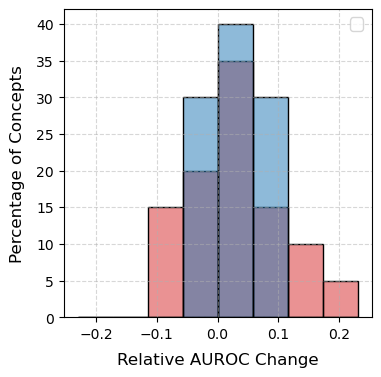

In [28]:
female_indices = order[:20]
male_indices = order[20:]

def plot_relative_auroc_change_histogram(auc_before, auc_after, indices1, indices2, num_bins=10, save_path=None):
    # Params
    fontsize=12
    labelpad=8
    alpha=0.5
    color1 = 'tab:red'
    color2 = 'tab:blue'

    # Convert inputs to numpy arrays
    auc_before = np.array(auc_before)
    auc_after = np.array(auc_after)
    
    # Compute relative change: (after - before) / before
    relative_change = (auc_after - auc_before) / auc_before
    
    # Determine bin boundaries based on the absolute range of relative change
    bound = max(np.abs(np.min(relative_change)), np.abs(np.max(relative_change)))
    bins = np.linspace(-bound, bound, num_bins + 1)
    
    # Create the figure (square) and axis
    plt.figure(figsize=(4, 4))
    ax = plt.gca()
    
    # Plot histogram for the first group using the provided indices
    sns.histplot(relative_change[indices1], bins=bins, stat='percent', 
                 edgecolor='black', alpha=alpha, color=color1, label='', ax=ax)
    
    # Plot histogram for the second group using the provided indices
    sns.histplot(relative_change[indices2], bins=bins, stat='percent', 
                 edgecolor='black', alpha=alpha, color=color2, label='', ax=ax)
    
    # Set aspect ratio to be square
    ax.set_box_aspect(1)

    # Add grid with alpha transparency
    ax.grid(True, which='both', linestyle='--', alpha=alpha)
    
    # Set axis labels and title
    plt.xlabel("Relative AUROC Change", fontsize=fontsize, labelpad=labelpad)
    plt.ylabel("Percentage of Concepts", fontsize=fontsize, labelpad=labelpad)
    
    plt.legend(fontsize=fontsize)
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

plot_relative_auroc_change_histogram(auc_hist[0,:], auc_hist[-1,:], female_indices, male_indices, num_bins=8)

## 7) Heatmaps

In [29]:
from models import get_canonizer
from utils.model import truncate_and_extend_vgg16, FlattenAndMaxPool
from zennit.composites import EpsilonPlusFlat
from utils.heatmaps import visualize_heatmaps
import random

entangled_pairs =[
    (9, 38),        # Blond Hair - Wearing Necktie
    (4, 31),        # Bald - Smiling
    (8, 38),        # Black Hair - Wearing Necktie
    (16, 9),        # Goatee - Blond Hair
    (16, 8),        # Goatee - Black Hair
]

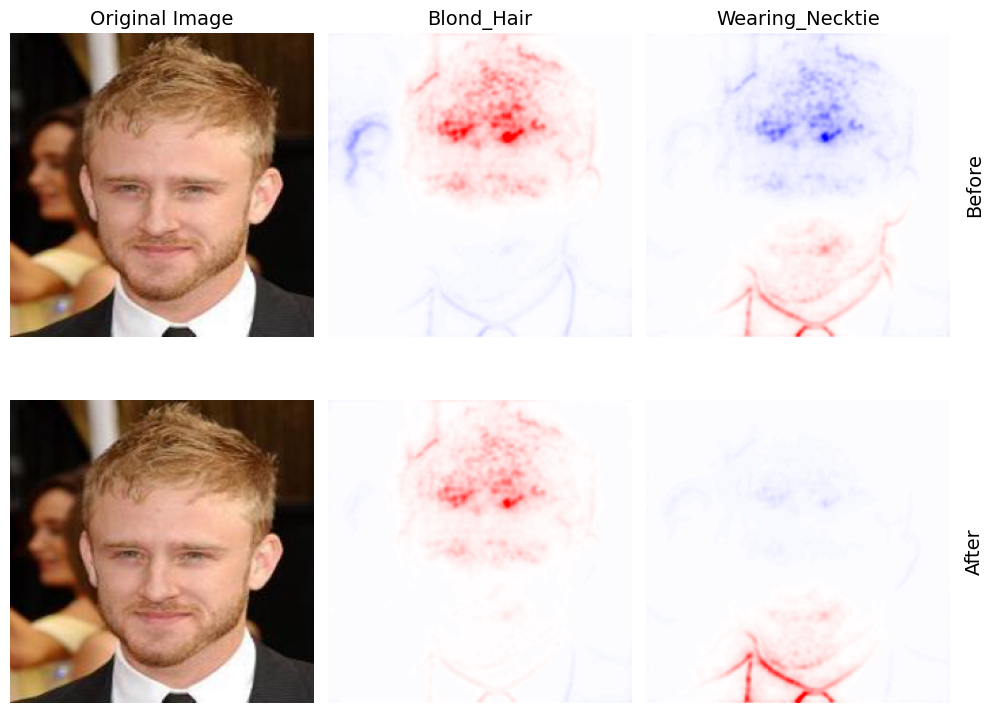

In [30]:
# Truncate and extend to obtain attribution models
model_cav_original = truncate_and_extend_vgg16(model, LAYER, FlattenAndMaxPool(), cavs_original).to(device)
model_cav_orthogonal = truncate_and_extend_vgg16(model, LAYER, FlattenAndMaxPool(), cavs_orthogonal).to(device)
attribution_original = CondAttribution(model_cav_original)
attribution_orthogonal = CondAttribution(model_cav_orthogonal)
canonizer = get_canonizer('vgg16')
composite = EpsilonPlusFlat()

pair = entangled_pairs[0]
n_samples = 1
concept1 = concepts[pair[0]]
concept2 = concepts[pair[1]]
samples1 = dataset.sample_ids_by_concept[concept1]
samples2 = dataset.sample_ids_by_concept[concept2]

# Get the intersection
random.seed(21)
samples = list(set(samples1).intersection(set(samples2)))
sample_ids = random.sample(samples, n_samples)
samples = [dataset[i][0].unsqueeze(0) for i in sample_ids]
samples = torch.vstack(samples)         # Shape [n_samples_each, 3, 224, 224]
samples.requires_grad_()

# Obtain Heatmaps
conditions = [{'y': [pair[0]]}, {'y': [pair[1]]}]
attr = attribution_orthogonal(samples.to(device), conditions, composite, record_layer=[LAYER])
attr_original = attribution_original(samples.to(device), conditions, composite, record_layer=[LAYER])
# dps_before = x_latent_all[sample_ids] @ cavs_original[list(pair)].T               # Shape [n, 2]
# dps_after = x_latent_all[sample_ids] @ cavs_orthogonal[list(pair)].T              # Shape [n, 2]
hms_before = attr_original.heatmap.reshape((n_samples, 2, attr.heatmap.shape[-2], attr.heatmap.shape[-1])).permute(1,0,2,3)
hms_after = attr.heatmap.reshape((n_samples, 2, attr.heatmap.shape[-2], attr.heatmap.shape[-1])).permute(1,0,2,3)


hms = [hms_before[0][0], hms_before[1][0], hms_after[0][0], hms_after[1][0]]
# dps = [dps_before[i, 0], dps_before[i, 1], dps_after[i, 0], dps_after[i, 1]]
dps = None
subtitles = ['Original Image' ,f'{concept1}', f'{concept2}']
visualize_heatmaps(samples[0].detach(), hms ,subplots_size=(2,3) ,suptitle=None, channel_avg=False, titles=subtitles, dot_products=dps, fontsize=14)